# Train - Dev - Test + MODEL 1-2


In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zipfile import ZipFile
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold

In [2]:
#GOOGLE COLAB VERSION
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Fri Sep  9 08:36:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
#JUPYTER VERSION
#comb_path = "../Data/Combined_Images"

#GOOGLE COLAB VERSION
from google.colab import drive
drive.mount('/content/drive')

# Unzipping the dataset file facial-age.zip

combined_images_path = '/content/drive/MyDrive/Data/Combined_Images_NEWRANGE.zip'

with ZipFile(combined_images_path, 'r') as myzip:
    myzip.extractall('../content/Combined_Images_NEWRANGE')
    print('Done unzipping Combined_Images_NEWRANGE.zip')

comb_path = '../content/Combined_Images_NEWRANGE'  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Done unzipping Combined_Images_NEWRANGE.zip


In short, there is not a good way to get the size/length; tf.data.Dataset is built for pipelines of data, so has an iterator structure (in my understanding and according to my read of the Dataset ops code. From the programmer's guide:

A tf.data.Iterator provides the main way to extract elements from a dataset. The operation returned by Iterator.get_next() yields the next element of a Dataset when executed, and typically acts as the interface between input pipeline code and your model.

And, by their nature, iterators do not have a convenient notion of size/length; see here: Getting number of elements in an iterator in Python

In [6]:
batch_size = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  comb_path,
  validation_split=0.2,
  subset="training", #If should be return the training set (80%) or the validation set (20%)
  seed=41, #Seed should guarantee that train_ds and val_ds doesn't have common images
  shuffle=True,
  image_size=(50, 50),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  comb_path,
  validation_split=0.2,
  subset="validation",
  seed=41, 
  shuffle=True,
  image_size=(50, 50),
  batch_size=batch_size)

test_dataset = val_ds.take(27)
val_ds = val_ds.skip(27)

print('Batches for training -->', train_ds.cardinality())
print('Batches for validating -->', val_ds.cardinality())
print('Batches for testing -->', test_dataset.cardinality())

Found 33884 files belonging to 8 classes.
Using 27108 files for training.
Found 33884 files belonging to 8 classes.
Using 6776 files for validation.
Batches for training --> tf.Tensor(212, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(26, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(27, shape=(), dtype=int64)


In [7]:
model1 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(50, 50, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(8, activation='softmax')
])

#model.compile(optimizer=tf.keras.optimizers.Adam(),
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              #metrics=tf.keras.metrics.Accuracy())*/

#Additionaly, if you do not one-hot encode your data, set sparse_categorical_crossentropy as loss and sparse_categorical_accuracy as metric.
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])

# Defining the early stop to monitor the validation loss to avoid overfitting.
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

epochs=30
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[early_stop],
  epochs=epochs,
  shuffle=True
)

Epoch 1/30
212/212 [==============================] - 55s 204ms/step - loss: 1.7498 - sparse_categorical_accuracy: 0.3725 - val_loss: 1.6605 - val_sparse_categorical_accuracy: 0.3988
Epoch 2/30
212/212 [==============================] - 45s 205ms/step - loss: 1.5674 - sparse_categorical_accuracy: 0.4197 - val_loss: 1.5231 - val_sparse_categorical_accuracy: 0.4370
Epoch 3/30
212/212 [==============================] - 44s 198ms/step - loss: 1.4675 - sparse_categorical_accuracy: 0.4542 - val_loss: 1.4876 - val_sparse_categorical_accuracy: 0.4419
Epoch 4/30
212/212 [==============================] - 42s 192ms/step - loss: 1.3923 - sparse_categorical_accuracy: 0.4785 - val_loss: 1.4298 - val_sparse_categorical_accuracy: 0.4630
Epoch 5/30
212/212 [==============================] - 43s 199ms/step - loss: 1.3319 - sparse_categorical_accuracy: 0.4997 - val_loss: 1.4115 - val_sparse_categorical_accuracy: 0.4642
Epoch 6/30
212/212 [==============================] - 43s 198ms/step - loss: 1.2737 -

In [8]:
train_label = np.concatenate([y for x, y in train_ds], axis=0)
val_label = np.concatenate([y for x, y in val_ds], axis=0)
test_label = np.concatenate([y for x, y in test_dataset], axis=0)

train_counts = pd.Series(train_label).value_counts().sort_index()
val_counts = pd.Series(val_label).value_counts().sort_index()
test_counts = pd.Series(test_label).value_counts().sort_index()

print('Training Set: ', len(train_label))
print('Validation Set: ', len(val_label))
print('Test Set: ', len(test_label), '\n-------------------')

print(train_counts, '\n-------------------')
print(val_counts, '\n-------------------')
print(test_counts, '\n-------------------')

Training Set:  27108
Validation Set:  3320
Test Set:  3456 
-------------------
0    2720
1    2297
2    2101
3    3201
4    8955
5    3655
6    1996
7    2183
dtype: int64 
-------------------
0     332
1     281
2     260
3     390
4    1097
5     439
6     248
7     273
dtype: int64 
-------------------
0     351
1     298
2     262
3     428
4    1155
5     427
6     248
7     287
dtype: int64 
-------------------


In [9]:
def loss_acc_graphs(history_model):
  fig, ax = plt.subplots(ncols=2, figsize=(15,7))

  ax = ax.ravel()

  ax[0].plot(history_model.history['loss'], marker='o', markersize=5)
  ax[0].plot(history_model.history['val_loss'], marker='o', markersize=5)
  ax[0].set_title('Model Loss', fontsize=18)
  ax[0].set_ylabel('loss', fontsize=14)
  ax[0].set_xlabel('epoch', fontsize=14)
  ax[0].legend(['train', 'val'], loc='upper left', fontsize=15)

  ax[1].plot(history_model.history['sparse_categorical_accuracy'], marker='o', markersize=5)
  ax[1].plot(history_model.history['val_sparse_categorical_accuracy'], marker='o', markersize=5)
  ax[1].set_title('Model Accuracy', fontsize=18)
  ax[1].set_ylabel('accuracy', fontsize=14)
  ax[1].set_xlabel('epoch', fontsize=14)
  ax[1].legend(['train', 'val'], loc='upper left', fontsize=15)
  plt.show()

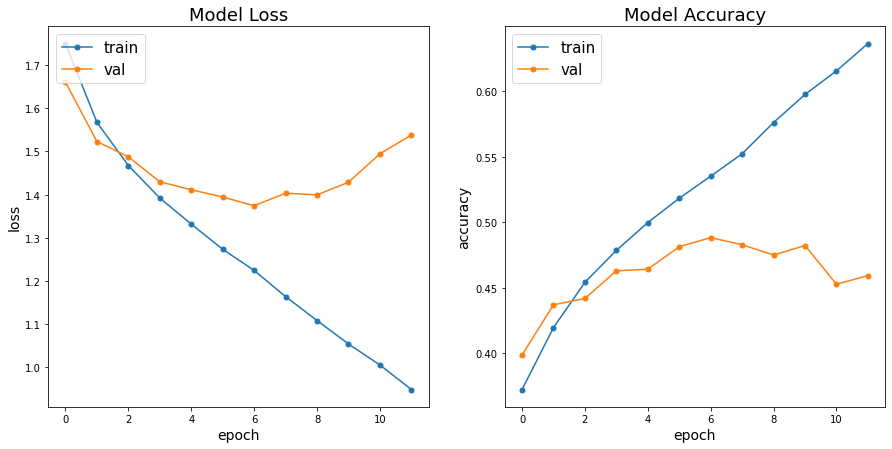

In [10]:
loss_acc_graphs(history)

C'è un enorme overfitting, dato il grande margine di accuracy tra train e val set, per limitarlo proviamo a implementare nel modello alcune regolarizzazioni (L2) e il Dropout

In [11]:
model2 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(50, 50, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'), #kernel_regularizer=regularizers.l2(l=0.01)
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'), #kernel_regularizer=regularizers.l2(l=0.01)
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'), #kernel_regularizer=regularizers.l2(l=0.01)
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(8, activation='softmax')
])

#model.compile(optimizer=tf.keras.optimizers.Adam(),
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              #metrics=tf.keras.metrics.Accuracy())

#Additionaly, if you do not one-hot encode your data, set sparse_categorical_crossentropy as loss and sparse_categorical_accuracy as metric.
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])

# Defining the early stop to monitor the validation loss to avoid overfitting.
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

epochs=25
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[early_stop],
  epochs=epochs,
  shuffle=True
)

Epoch 1/25
212/212 [==============================] - 41s 184ms/step - loss: 1.8595 - sparse_categorical_accuracy: 0.3440 - val_loss: 1.7857 - val_sparse_categorical_accuracy: 0.3687
Epoch 2/25
212/212 [==============================] - 48s 218ms/step - loss: 1.7244 - sparse_categorical_accuracy: 0.3822 - val_loss: 1.6876 - val_sparse_categorical_accuracy: 0.4042
Epoch 3/25
212/212 [==============================] - 45s 204ms/step - loss: 1.6278 - sparse_categorical_accuracy: 0.4053 - val_loss: 1.5956 - val_sparse_categorical_accuracy: 0.4190
Epoch 4/25
212/212 [==============================] - 42s 192ms/step - loss: 1.5714 - sparse_categorical_accuracy: 0.4218 - val_loss: 1.5383 - val_sparse_categorical_accuracy: 0.4349
Epoch 5/25
212/212 [==============================] - 41s 188ms/step - loss: 1.5327 - sparse_categorical_accuracy: 0.4312 - val_loss: 1.4951 - val_sparse_categorical_accuracy: 0.4470
Epoch 6/25
212/212 [==============================] - 41s 188ms/step - loss: 1.4961 -

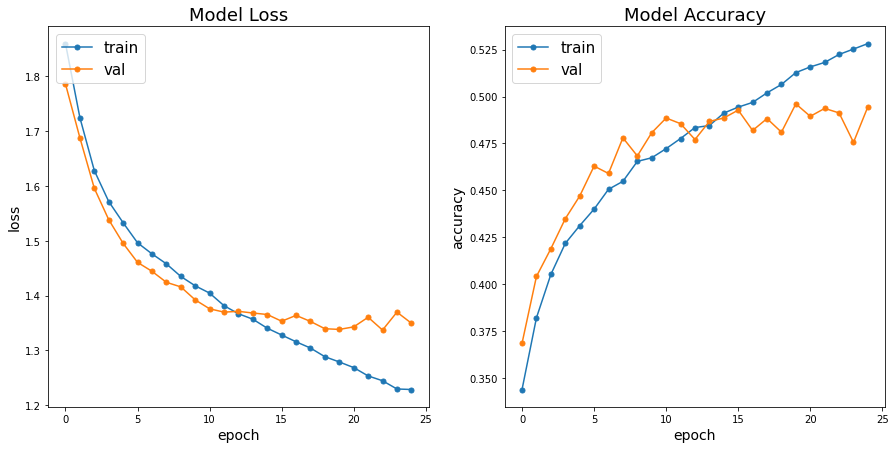

In [12]:
loss_acc_graphs(history)

In [13]:
#I need to get labels from validation dataset for construct the confusion matrix, but I can't get labels with normal order without recreating the dataset with disabled 
#the shuffle. Any idea? Probably, there are any ways to get prediction together with labels? (how is, model.evaluate() works with shuffle)
# That is a workaround, doing the average acc for the batches

#acc_tot = 0
#count = 0
#for images, labels in val_ds:
    #count += 1
    #preds = model.predict(images)
    #acc_sc = accuracy_score(labels, tf.argmax(preds, axis=1))
    #acc_tot += acc_sc

#print(round(acc_tot/count, 4))

In [14]:
print("MODEL 1 --- Without Regularization")
model1.evaluate(test_dataset)

MODEL 1 --- Without Regularization
27/27 [==============================] - 6s 167ms/step - loss: 1.4800 - sparse_categorical_accuracy: 0.4685


[1.4800217151641846, 0.46846064925193787]

In [15]:
print("MODEL 2 --- With Dropout Regularization")
model2.evaluate(test_dataset)

MODEL 2 --- With Dropout Regularization
27/27 [==============================] - 5s 151ms/step - loss: 1.3434 - sparse_categorical_accuracy: 0.5046


[1.3433876037597656, 0.5046296119689941]